# Filtering and trimming messages 

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [25]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_groq

In [26]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`.

**Note:** LangSmith is optional. You can skip this cell if you don't want to use it.

In [27]:
# Optional: Uncomment to use LangSmith tracing
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [28]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage("So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [29]:
from langchain_groq import ChatGroq

# Initialize Groq with Llama model
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
result = llm.invoke(messages)
print(result.content)

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the world and are known for their agility and playful nature. They're closely related to walruses and share similar characteristics.
3. **Walruses**: Large, tusked mammals that inhabit the Arctic and sub-Arctic regions, walruses are well adapted to their icy environments and are skilled divers.
4. **Manatees**: Also known as sea cows, manatees are large, gentle herbivores that inhabit shallow waters in the Caribbean and Gulf of Mexico.
5. **Dugongs**: Similar to manatees, dugongs are large marine mammals that feed on sea grasses and are found in shallow waters in the Indo-Pacific region.
6. **Otters**: While not exc

We can run our chat model in a simple graph with `MessagesState`.

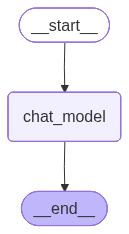

In [30]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the world and are known for their agility and playful nature. They're closely related to walruses and share similar characteristics.
3. **Walruses**: Large, tusked mammals that inhabit the Arctic and sub-Arctic regions, walruses are well adapt

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

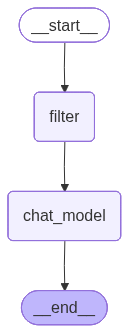

In [32]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the world and are known for their agility and playful nature. They're closely related to walruses and share similar characteristics.
3. **Walruses**: Large, tusked mammals that inhabit the Arctic and sub-Arctic regions, walruses are well adapt

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

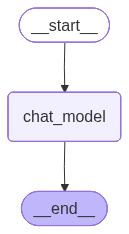

In [34]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [35]:
messages.append(output['messages'][-1])
messages.append(HumanMessage("Tell me more about Narwhals!", name="Lance"))

In [36]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the world and are known for their agility and pla

In [37]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the world and are known for their agility and pla

The state has all of the messages.

But, the model invocation only uses the last message.

## Trim messages

Another approach is to trim messages based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

We use `len` as a simple token counter (counts characters). For more accurate token counting, you could use word count or integrate with a tokenizer.

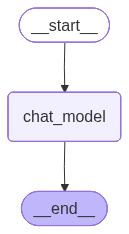

In [38]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    # Use len as token counter - simpler and doesn't require transformers
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=len,  # Use len instead of model for token counting
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
messages.append(output['messages'][-1])
messages.append(HumanMessage("Tell me where Orcas live!", name="Lance"))

In [40]:
# Example of trimming messages
trimmed = trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=len,  # Use len instead of model for token counting
            allow_partial=False
        )

print(f"Original messages: {len(messages)}")
print(f"Trimmed messages: {len(trimmed)}")
for m in trimmed:
    m.pretty_print()

Original messages: 8
Trimmed messages: 8
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the worl

In [41]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few examples:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are found in oceans around the world and are known for their agility and pla